--2024-09-27 12:08:02--  https://github.com/IdePHICS/FundamentalLearningEPFL/raw/main/TP2/where_is_the_light.npy
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IdePHICS/FundamentalLearningEPFL/main/TP2/where_is_the_light.npy [following]
--2024-09-27 12:08:02--  https://raw.githubusercontent.com/IdePHICS/FundamentalLearningEPFL/main/TP2/where_is_the_light.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80128 (78K) [application/octet-stream]
Saving to: ‘where_is_the_light.npy.2’

where_is_the_light. 100%[===================>]  78.25K  --.-KB/s    in 0.03s   

2024-09-27 12:08:03 (2.49 MB/s) -

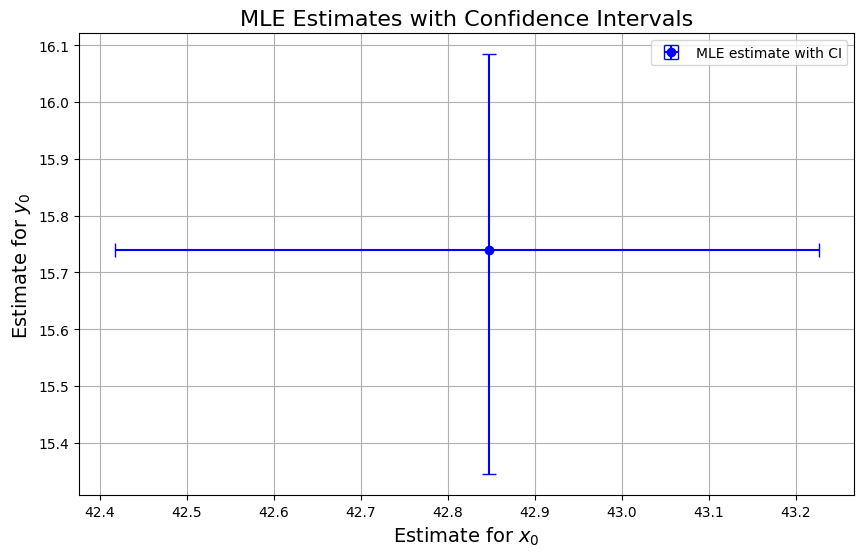

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.random import choice
from numpy import percentile

!wget https://github.com/IdePHICS/FundamentalLearningEPFL/raw/main/TP2/where_is_the_light.npy
data = np.load('where_is_the_light.npy')

# A: Define the log-likelihood function for x0 and y0 as seen in the exercise session
def loglh(x0, y0, x):
    log = 0
    for i in x:
        log += np.log(y0 / ((y0**2 + (i - x0)**2) * np.pi))  # Cauchy likelihood distribution
    return log

# B: Define the function that outputs the maximum likelyhood values for x0 and y0
def MLE_estimation(data):
    def f(params):   #lets use a nested function "f" to find the log-likelihood of the parameters x0 and y0.
        x0, y0 = params
        return -loglh(x0, y0, data)  #negative bc then we use minimize, so we find the maximum

    xy0 = (np.random.uniform(20, 60), np.random.uniform(0, 30))  # Initial guesses
    optimum = minimize(f, xy0, method='Nelder-Mead')  # Minimize the negative log-likelihood
    return optimum.x  # Return estimated x0 and y0

# C: Define the bootstrapping function, this will generate N_boot new datasets based on the given one to compute the CI
def bootstrap_MLE(data, N_boot=50):
    bootstrapped_params = np.zeros((N_boot, 2))  # Store bootstrapped estimates for x0 and y0, 2D array bc we have two values

    for i in range(N_boot):    #loop N_boot times

        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_params[i] = MLE_estimation(bootstrap_sample)  # Perform MLE for each bootstrap sample


    x0_estimates = bootstrapped_params[:, 0]           #The first column of the array saves all the bootstrapped values of x0
    y0_estimates = bootstrapped_params[:, 1]           #The second column of the array saves all the bootstrapped values of y0

    # Calculate confidence intervals for x0 and y0 (2.5th and 97.5th percentiles)
    x0_CI = np.percentile(x0_estimates, [2.5, 97.5])
    y0_CI = np.percentile(y0_estimates, [2.5, 97.5])

    # Calculate mean estimates (MLE point estimates)
    x0_MLE_mean = x0_estimates.mean()
    y0_MLE_mean = y0_estimates.mean()

    return (x0_MLE_mean, y0_MLE_mean), (x0_CI, y0_CI), (x0_estimates, y0_estimates)    #Format the function returns the variables in

# D: Perform the bootstrapping for MLE estimates and confidence intervals, the variables have different names than before as those are internal, while for the rest of the code I will use these
N_boot = 50
(mle_x0, mle_y0), (CI_x0, CI_y0), (x0_estimates_MLE, y0_estimates_MLE) = bootstrap_MLE(data, N_boot)

# E: Results
print(f"MLE estimate for x0: {mle_x0} with 95% CI: {CI_x0}")
print(f"MLE estimate for y0: {mle_y0} with 95% CI: {CI_y0}")



fig, ax = plt.subplots(figsize=(10, 6))     #Initialize graph
plt.title('MLE Estimates with Confidence Intervals', fontsize=16)


ax.errorbar(mle_x0, mle_y0,
            xerr=[[mle_x0 - CI_x0[0]], [CI_x0[1] - mle_x0]], # Plot MLE point estimates, ans use the errorbar tool to plot error bars also
            yerr=[[mle_y0 - CI_y0[0]], [CI_y0[1] - mle_y0]],
            fmt='o', color='b', label='MLE estimate with CI', capsize=5)

ax.set_xlabel('Estimate for $x_0$', fontsize=14)   # Label axes
ax.set_ylabel('Estimate for $y_0$', fontsize=14)

plt.legend()
plt.grid(True)
plt.show()







Jeffreys MLE estimate for x0: 42.90636744151071 with 95% CI: [42.54791581 43.26669607]
Jeffreys MLE estimate for y0: 15.742815098500262 with 95% CI: [15.35097204 16.19880071]


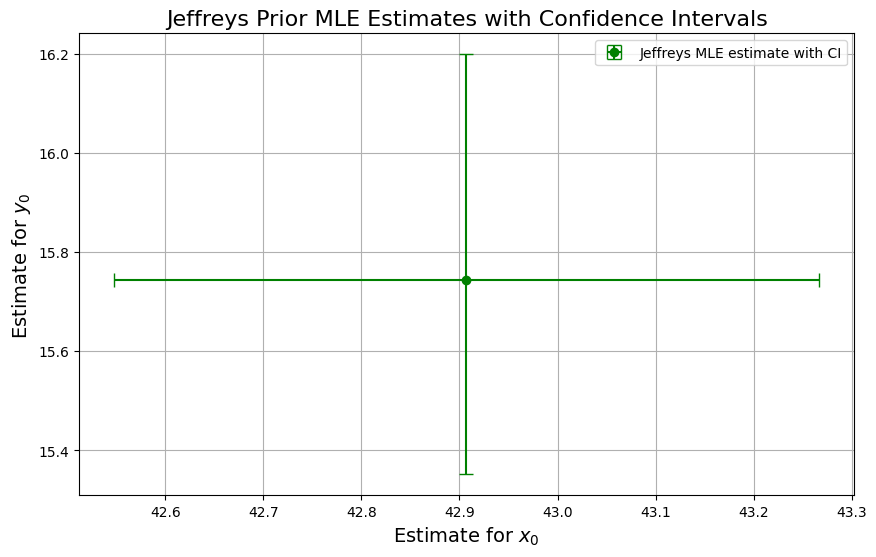

In [14]:
#From the theory we know that when we have a uniform prior, maximimizing the log-likelihood means maximizing the posterior, so we must now move on to analyzing the problem with jeffreys prior

# A: Define the log-posterior with Jeffreys Prior, almost the same as above
def jeffreys_prior_logposterior(x0, y0, x):
    if y0 <= 0:
        return -np.inf  # Prevent negative or zero y0, it is a condition for the Jeffreys prior
    # Jeffreys prior: log(1/y0) is the log of the Jeffreys prior for Cauchy distribution
    log_prior = -np.log(y0)  # Jeffreys prior term for y0
    log_likelihood = loglh(x0, y0, x)
    return log_prior + log_likelihood

# B: from now on basically identical
def MLE_estimation_jeffreys(data):
    def f(params):
        x0, y0 = params
        return -jeffreys_prior_logposterior(x0, y0, data)

    xy0 = (np.random.uniform(20, 60), np.random.uniform(0, 30))
    optimum = minimize(f, xy0, method='Nelder-Mead')
    return optimum.x


def bootstrap_MLE_jeffreys(data, N_boot=50):
    bootstrapped_params = np.zeros((N_boot, 2))

    for i in range(N_boot):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_params[i] = MLE_estimation_jeffreys(bootstrap_sample)


    x0_estimates = bootstrapped_params[:, 0]
    y0_estimates = bootstrapped_params[:, 1]

    x0_CI = np.percentile(x0_estimates, [2.5, 97.5])
    y0_CI = np.percentile(y0_estimates, [2.5, 97.5])

    x0_MLE_mean = x0_estimates.mean()
    y0_MLE_mean = y0_estimates.mean()

    return (x0_MLE_mean, y0_MLE_mean), (x0_CI, y0_CI), (x0_estimates, y0_estimates)

(mle_x0_jeffreys, mle_y0_jeffreys), (CI_x0_jeffreys, CI_y0_jeffreys), (x0_estimates_jeffreys, y0_estimates_jeffreys) = bootstrap_MLE_jeffreys(data, N_boot=50)

print(f"Jeffreys MLE estimate for x0: {mle_x0_jeffreys} with 95% CI: {CI_x0_jeffreys}")
print(f"Jeffreys MLE estimate for y0: {mle_y0_jeffreys} with 95% CI: {CI_y0_jeffreys}")

fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Jeffreys Prior MLE Estimates with Confidence Intervals', fontsize=16)

ax.errorbar(mle_x0_jeffreys, mle_y0_jeffreys,
            xerr=[[mle_x0_jeffreys - CI_x0_jeffreys[0]], [CI_x0_jeffreys[1] - mle_x0_jeffreys]],
            yerr=[[mle_y0_jeffreys - CI_y0_jeffreys[0]], [CI_y0_jeffreys[1] - mle_y0_jeffreys]],
            fmt='o', color='g', label='Jeffreys MLE estimate with CI', capsize=5)

ax.set_xlabel('Estimate for $x_0$', fontsize=14)
ax.set_ylabel('Estimate for $y_0$', fontsize=14)

plt.legend()
plt.grid(True)
plt.show()


In [21]:
# BONUS: To compare the performance of the uniform and Jeffreys prior (part 1 and 2 of the code respectively) it would be cool to use the Cramer-Rao bound
# Unfortunately we do not possess this information so we can only use the MSE from the bootstrapped estimates and the lengths of the confidence intervals.

def compute_MSE(estimates, mean_estimate):
    return np.mean((estimates - mean_estimate) ** 2)

MSE_x0_MLE = compute_MSE(x0_estimates_MLE, mle_x0)
MSE_y0_MLE = compute_MSE(y0_estimates_MLE, mle_y0)

MSE_x0_jeffreys = compute_MSE(x0_estimates_jeffreys, mle_x0_jeffreys)
MSE_y0_jeffreys = compute_MSE(y0_estimates_jeffreys, mle_y0_jeffreys)

print(f"MSE for MLE: x0 = {MSE_x0_MLE}, y0 = {MSE_y0_MLE}")
print(f"MSE for Jeffreys Prior: x0 = {MSE_x0_jeffreys}, y0 = {MSE_y0_jeffreys}")

CI_width_x0_MLE = CI_x0[1] - CI_x0[0]
CI_width_y0_MLE = CI_y0[1] - CI_y0[0]

CI_width_x0_jeffreys = CI_x0_jeffreys[1] - CI_x0_jeffreys[0]
CI_width_y0_jeffreys = CI_y0_jeffreys[1] - CI_y0_jeffreys[0]

print(f"Confidence Interval width for MLE: x0 = {CI_width_x0_MLE}, y0 = {CI_width_y0_MLE}")
print(f"Confidence Interval width for Jeffreys Prior: x0 = {CI_width_x0_jeffreys}, y0 = {CI_width_y0_jeffreys}")

if MSE_x0_MLE < MSE_x0_jeffreys:
    print("For x0, MLE has lower MSE than Jeffreys Prior.")
else:
    print("For x0, Jeffreys Prior has lower MSE than MLE.")

if MSE_y0_MLE < MSE_y0_jeffreys:
    print("For y0, MLE has lower MSE than Jeffreys Prior.")
else:
    print("For y0, Jeffreys Prior has lower MSE than MLE.")

if CI_width_x0_MLE < CI_width_x0_jeffreys:
    print("For x0, MLE has a narrower confidence interval than Jeffreys Prior.")
else:
    print("For x0, Jeffreys Prior has a narrower confidence interval than MLE.")

if CI_width_y0_MLE < CI_width_y0_jeffreys:
    print("For y0, MLE has a narrower confidence interval than Jeffreys Prior.")
else:
    print("For y0, Jeffreys Prior has a narrower confidence interval than MLE.")

MSE for MLE: x0 = 0.04591964071057194, y0 = 0.045866435982134905
MSE for Jeffreys Prior: x0 = 0.03752642834814773, y0 = 0.0471136352560032
Confidence Interval width for MLE: x0 = 0.8095346147261537, y0 = 0.7394380908520883
Confidence Interval width for Jeffreys Prior: x0 = 0.7187802528080525, y0 = 0.8478286775531156
For x0, Jeffreys Prior has lower MSE than MLE.
For y0, MLE has lower MSE than Jeffreys Prior.
For x0, Jeffreys Prior has a narrower confidence interval than MLE.
For y0, MLE has a narrower confidence interval than Jeffreys Prior.
